In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time

import gspread
from google.oauth2.service_account import Credentials


In [ ]:
# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = "../velvety-tube-450516-r5-2dfa430c056c.json" 


# Define the scope (Google Sheets + Google Drive API)
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive.file",  # Allows access to files the service account has access to
    "https://www.googleapis.com/auth/drive.readonly"  # Read-only access to drive files
]
# Authenticate with Google
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

    

In [ ]:
# Get names of all sheets
SPREADSHEET_NAME = "Matheus_counterexamples"

spreadsheet = client.open(SPREADSHEET_NAME)
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
print("Sheets in the spreadsheet:")
for name in sheet_names:
    print(f"  {name}")

Sheets in the spreadsheet:
  Sheet1
  RNN_sparse_majority_k5_nbits10_n200_bf10_seed1234_results
  counterexample_test0


In [6]:
target = "counterexample_test0"

target_idx = name_to_idx.get(target)
print("Loading:", target)
sheet = spreadsheet.get_worksheet(target_idx)
data = sheet.get_all_records()

Loading: counterexample_test0


In [7]:
df = pd.DataFrame(data)


In [8]:
df.head()

,epoch,train_loss,train_acc,val_acc,noiseless_val_acc,final_train_acc,final_val_acc,final_noiseless_val_acc,sensitivity
0,1,0.722980,0.518353,0.522764,0.562800,0.518353,0.522764,0.562800,3.0648
1,2,0.700198,0.490575,0.490615,0.490315,0.490575,0.490615,0.490315,0.1440
2,3,0.704033,0.506448,0.501098,0.517372,0.506448,0.501098,0.517372,0.9875
3,4,0.703677,0.506448,0.501098,0.517372,0.506448,0.501098,0.517372,0.9875
4,5,0.700554,0.535714,0.537839,0.625899,0.535714,0.537839,0.625899,2.2591


In [41]:
# find idx of minimum validation error
max_idx = df['val_acc'].idxmax()
print(max_idx)

68


In [42]:
x = df["sensitivity"].values[:max_idx]
y1 = 1- df["val_acc"].values[:max_idx]
y2 = 1-df["train_acc"].values[:max_idx]

In [43]:
# coordinates of [sensitivity, error] for noisy optimal (fn*) and noiseless function f
fnstar_coords = np.array(( 1.875, 1 - np.float64(0.6042299999999998)))
f_coords = np.array(( 2.5, 1 - np.float64(0.5828199999999999)))

In [44]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

In [45]:
def make_collection(x, y):
    # Create segments from the x and y points
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a custom colormap from dark purple (#4B0082) to yellow (#FFFF00)
    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#4B0082", "#FFFF00"])

    # Create a LineCollection with the segments and assign a gradient
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(0, 1))
    # Set an array for the colormap that goes from 0 (start) to 1 (end)
    lc.set_array(np.linspace(0, 1, len(segments)))
    lc.set_linewidth(2)
    return lc


Text(0.5, 1.0, 'Training error')

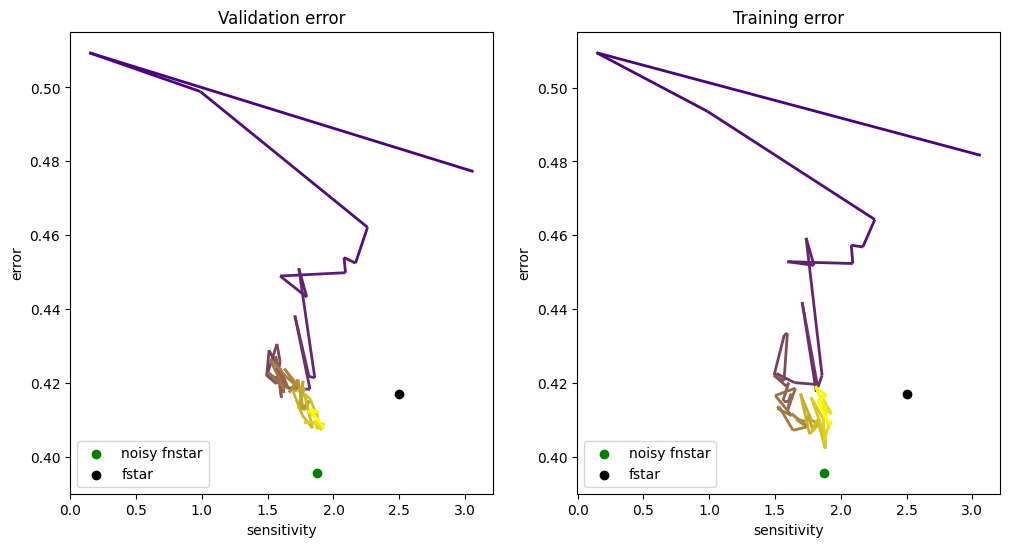

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


lc1 = make_collection(x, y1)
lc2 = make_collection(x, y2)
axes[0].add_collection(lc1)
axes[1]. add_collection(lc2)

for ax in axes:
    ax.scatter(*(fnstar_coords.T), color="green", label="noisy fnstar")
    ax.scatter(*(f_coords.T), color="black", label="fstar")
    # ax.plot(sensitivity_history, error_history, color="purple", label="transformer")
    ax.set_ylabel("error")
    ax.set_xlabel("sensitivity")
    # ax.set_xlim(1, 3)
    # ax.set_ylim(0, 0.6)
    ax.legend(loc="lower left")
axes[0].set_title("Validation error")
axes[1].set_title("Training error")


#### DIFFERENT WAYS OF GETTING SEPEARATION
 - higher noise rate
	pros: bigger separation guaranteed
	cons: accuracies are like entanglement harvesting
 - bigger $n$
    pros: "amplifies" existing separation
    cons: _EXPENSIVE_ to compute, and to find.
         - problems: For $n$ bits, there are $2^{2^n}$ boolean functions
 - bigger "imbalance" 
    cons: large imbalance is kind of "fishy". It makes the function look very atypical among boolean functions

### Do not touch:

In [5]:
bf_vals = [0, 10, 20]
best_n = 1
complete_df_dct = {}
for counterexample_str in ["100110", "011010", "011000"]:
    SPREADSHEET_NAME = f"counterexample{counterexample_str}_nbits20_n2000"
    spreadsheet = client.open(SPREADSHEET_NAME)
    sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
    name_to_idx = {}
    for i, name in enumerate(sheet_names):
        name_to_idx[name] = i

    df_dct = {
        "RNN": {}, 
        "SAN": {}
                }

    best_dct = {
        "RNN": {"noiseless": [], "noisy": [], "train_acc": []}, 
        "SAN": {"noiseless": [], "noisy": [], "train_acc": []}
                }

    for k in best_dct.keys():
        if k == "RNN":
            continue
        sheetname_template = '{}_counterexample' + counterexample_str + '_nbits20_n2000_bf{}_seed1234_results'
        for bf in bf_vals:
            target = sheetname_template.format(k, bf)
            target_idx = name_to_idx.get(target)
            print("Loading:", target)
            sheet = spreadsheet.get_worksheet(target_idx)
            data = sheet.get_all_records()

            df = pd.DataFrame(data)
            df_dct[k][bf] = df
            best_noiseless = df.sort_values(by='val_acc', ascending=False).head(best_n)['noiseless_val_acc'].to_numpy()
            best_training = df.sort_values(by='val_acc', ascending=False).head(best_n)['train_acc'].to_numpy()

            best_noisy = df.sort_values(by='val_acc', ascending=False).head(best_n)['val_acc'].to_numpy()
            best_dct[k]["noiseless"].append(best_noiseless)
            best_dct[k]["noisy"].append(best_noisy)
            best_dct[k]["train_acc"].append(best_training)
            
    complete_df_dct[counterexample_str] = df_dct


Loading: SAN_counterexample100110_nbits20_n2000_bf0_seed1234_results
Loading: SAN_counterexample100110_nbits20_n2000_bf10_seed1234_results
Loading: SAN_counterexample100110_nbits20_n2000_bf20_seed1234_results
Loading: SAN_counterexample011010_nbits20_n2000_bf0_seed1234_results
Loading: SAN_counterexample011010_nbits20_n2000_bf10_seed1234_results
Loading: SAN_counterexample011010_nbits20_n2000_bf20_seed1234_results
Loading: SAN_counterexample011000_nbits20_n2000_bf0_seed1234_results
Loading: SAN_counterexample011000_nbits20_n2000_bf10_seed1234_results
Loading: SAN_counterexample011000_nbits20_n2000_bf20_seed1234_results


So the hypothesis is, $f_N^*$ is very different from $f$, so we expect to only be able to learn one of the other. 

In [6]:
complete_df_dct.keys()

dict_keys(['100110', '011010', '011000'])

COUNTEREXAMPLE STRING: 100110
COUNTEREXAMPLE STRING: 011010
COUNTEREXAMPLE STRING: 011000


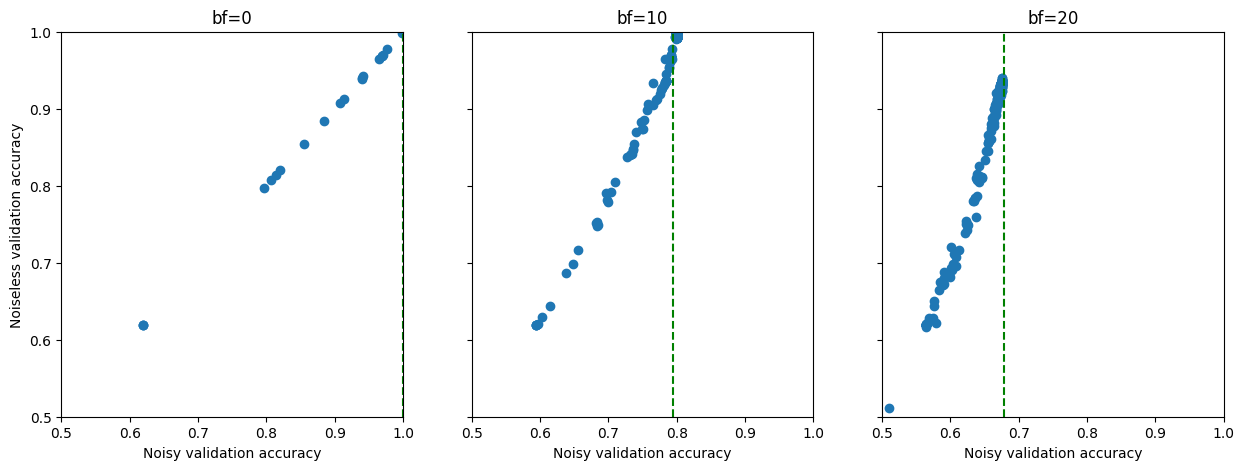

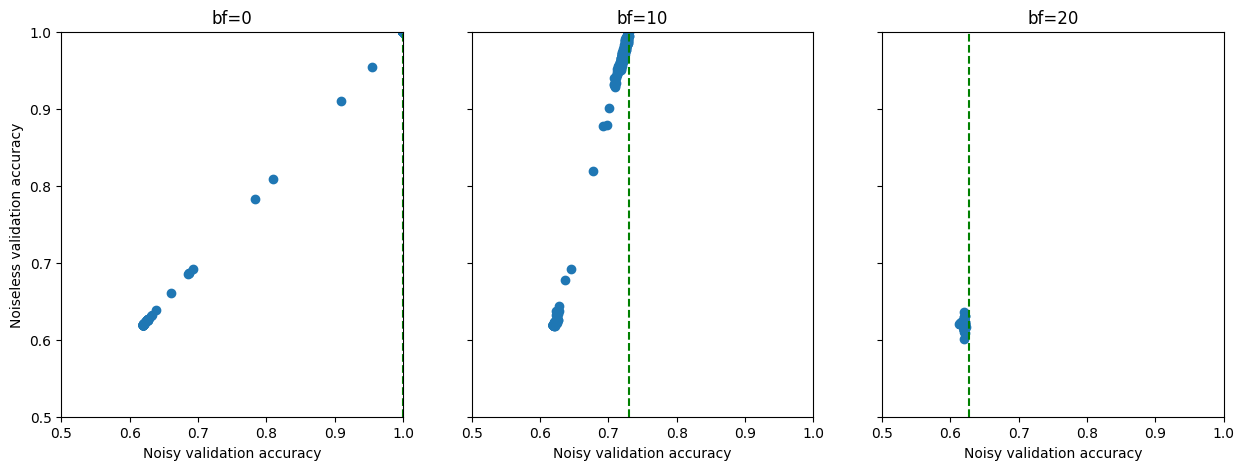

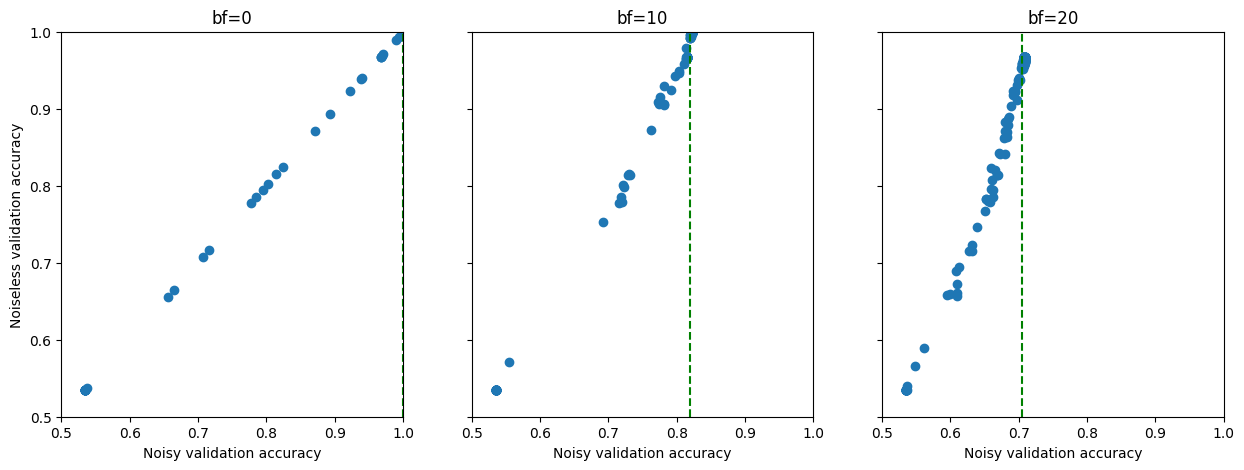

In [ ]:
# These are the true accuracies for f and fn* on noisy data
truth_dct = {
    "100110": {
        "f": [1, 0.7952399999999998, 0.6636800000000003],
        "fn*": [1, 0.7952399999999998, 0.6780200000000001],
    },
	"011010":{
		"f": [np.float64(1.0), np.float64(0.7305000000000005), np.float64(0.6070000000000002)],
		"fn*": [np.float64(1.0), np.float64(0.7305000000000005), np.float64(0.6270500000000001)]
    },
	"011000": {
		"f": [np.float64(1.0), np.float64(0.819765625), np.float64(0.6984999999999999)],
		"fn*": [np.float64(1.0), np.float64(0.819765625), np.float64(0.7056499999999999)]
    }
}

for counterexample_str, df_dct in complete_df_dct.items():
    print("COUNTEREXAMPLE STRING:", counterexample_str)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i, bf in enumerate(bf_vals):
        df = df_dct["SAN"][bf]
        x = df['val_acc']
        y = df['noiseless_val_acc']
        axes[i].scatter(x, y, label=f"bf={bf}")
        axes[i].set_title(f"bf={bf}")
        axes[i].set_xlabel("Noisy validation accuracy")
        true_fn = truth_dct[counterexample_str]["fn*"][i]
        # axes[i].axhline(true_f, color='r', linestyle='--', label="f")
        axes[i].axvline(true_fn, color='g', linestyle='--', label="fn*")
        axes[i].set_xlim(0.5, 1)
        axes[i].set_ylim(0.5, 1)
    axes[0].set_ylabel("Noiseless validation accuracy")


In [7]:

all_H = []
all_mle = []
p_bitflips = [bf / 100 for bf in bf_vals]
def sparse_majority_k5(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_majority_k_n(n_bits, 5, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

# Generate data with bitflip values
seed = 1234 
n_data = 100000 # ~maximum~ amount of data to analyze
inc = 50000 # increment at which to check convergence
assert inc < n_data
n_bits = 6 # HACK: We only consider the bits that actually contribute to the majority vote
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle_noisy = []
all_mle_noiseless = []

for i in range(len(p_bitflips)):
    t0 = time.time()
    X, Z, idx = sparse_majority_k5(n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    # compute the mle performance and the mle lookup table for this dataset
    H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle_noisy.append(mle_results)
    # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
    t0 = time.time()
    mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
    print("computed noiseless MLE for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_mle_noiseless.append(mle_noiseless)

generated data for p_bitflip =  0.0  took  0.6177277565002441  seconds
computed entropy for p_bitflip =  0.0  took  0.13873648643493652  seconds
computed noiseless MLE for p_bitflip =  0.0  took  0.2503983974456787  seconds
generated data for p_bitflip =  0.05  took  0.5796146392822266  seconds
computed entropy for p_bitflip =  0.05  took  0.1281731128692627  seconds
computed noiseless MLE for p_bitflip =  0.05  took  0.2455432415008545  seconds
generated data for p_bitflip =  0.1  took  0.5589971542358398  seconds
computed entropy for p_bitflip =  0.1  took  0.11803054809570312  seconds
computed noiseless MLE for p_bitflip =  0.1  took  0.2360069751739502  seconds
generated data for p_bitflip =  0.15  took  0.5429975986480713  seconds
computed entropy for p_bitflip =  0.15  took  0.11796832084655762  seconds
computed noiseless MLE for p_bitflip =  0.15  took  0.24401044845581055  seconds
generated data for p_bitflip =  0.2  took  0.5422854423522949  seconds
computed entropy for p_bitf

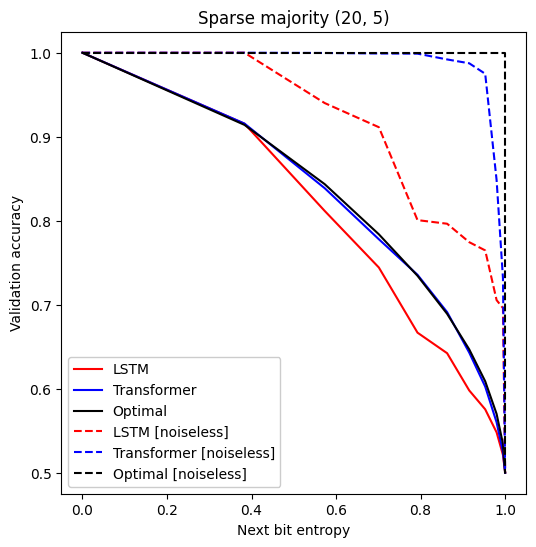

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
def append_last(x, y):
    # return (x, y)
    return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()

xvals = np.array([x[-1] for x in all_H])
mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])
# xvals = p_bitflips


if best_n == 1:
    rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
    rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
    san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
    san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()

    axes.plot(*append_last(xvals, rnn_noisy), label='LSTM', c='r', ls='-')
    axes.plot(*append_last(xvals, san_noisy), label='Transformer', c='b', ls='-')
    axes.plot(*append_last(xvals, mle_noisy_final), label='Optimal', c='k', ls='-')

    axes.plot(*append_last(xvals, rnn_noiseless), label='LSTM [noiseless]', c='r', ls='--')
    axes.plot(*append_last(xvals, san_noiseless), label='Transformer [noiseless]', c='b', ls='--')
    axes.plot([0, 1, 1], [1, 1, 0.5], label='Optimal [noiseless]', c='k', ls='--')

else:
    axes.plot(np.repeat(bf, best_n), best_dct["RNN"]["noiseless"][i], label='LSTM', c='r', marker='o', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["SAN"]["noiseless"][i], label='Transformer', c='b', marker='o', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["RNN"]["noisy"][i], label='LSTM', c='r', marker='x', s=15)
    axes.plot(np.repeat(bf, best_n), best_dct["SAN"]["noisy"][i], label='Transformer', c='b', marker='x', s=15)

# plot the noiseless mle by hand

leg_prop = {'size': 10}
axes.legend(prop=leg_prop, framealpha=1)
axes.set_title("Sparse majority (20, 5)")
axes.set_xlabel('Next bit entropy')
axes.set_ylabel('Validation accuracy')
print()
# axes.plot(np.repeat(bf_vals, best_n), best_dct["RNN"].flatten(), axis=1, label='RNN')
# axes.plot(np.repeat(bf_vals, best_n), best_dct["SAN"].flatten(), axis=1, label='SAN')